## Description
In this notebook, I analyze the data created in notebook 0. I compare images obtained from monoisotopic peak intensities and from regression.  

## Data loading

In [1]:
%matplotlib notebook

In [2]:
from masserstein import Spectrum, estimate_proportions
from pyimzml.ImzMLParser import ImzMLParser
from matplotlib import pyplot as plt
import numpy as np

In [3]:
TG_50_8 = 'C53H86O6'
PC_38_0 = 'C46H92NO8P'
PC_38_1 = 'C46H90NO8P'
PS_38_0 = 'C44H86NO10P'
PA_44_0 = 'C47H93O8P'

In [4]:
formulas = [PC_38_1, PA_44_0, PC_38_0, TG_50_8, PS_38_0]
names = ['PC(38:1)', 'PA(44:0)', 'PC(38:0)', 'TG(50:8)', 'PS(38:0)']
spectra = [Spectrum(f, adduct='K', threshold=0.001, label=n) for f, n in zip(formulas, names)]
for s in spectra:
    s.normalize()

In [5]:
monoisotopic_masses = [s.confs[0][0] for s in spectra]

In [6]:
profile_image = ImzMLParser('lipid_MSI_profile_mode.imzML')
centroid_image = ImzMLParser('lipid_MSI_centroid_mode.imzML')

In [7]:
image_shape = profile_image.coordinates[-1][:2]

In [8]:
image_shape = (image_shape[0]+1, image_shape[1]+1)  
image_shape

(50, 50)

## Ion images

In [9]:
profile_ion_images = np.zeros(image_shape  + (len(spectra), ))
centroid_ion_images = np.zeros(image_shape + (len(spectra), ))

In [10]:
for idx, (x,y,z) in enumerate(profile_image.coordinates):
    mz, intsy = profile_image.getspectrum(idx)
    mz = np.array(mz)
    for i, m in enumerate(monoisotopic_masses):
        peak_id = np.argmin(np.abs(mz-m))
        profile_ion_images[x, y, i] = intsy[peak_id]
    mz, intsy = centroid_image.getspectrum(idx)
    mz = np.array(mz)
    for i, m in enumerate(monoisotopic_masses):
        peak_id = np.argmin(np.abs(mz-m))
        centroid_ion_images[x, y, i] = intsy[peak_id]

<IPython.core.display.Javascript object>


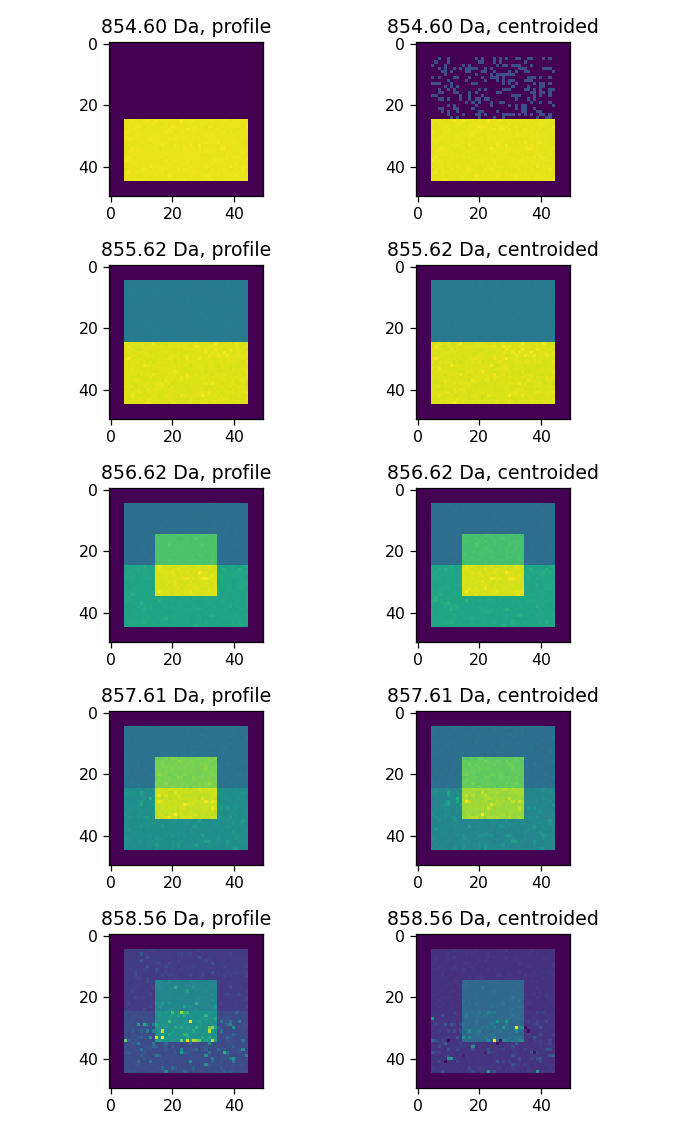

In [11]:
plt.figure(figsize=(6, 2*len(spectra)))
for i in range(len(spectra)):
    plt.subplot(len(spectra), 2, 1+2*i)
    plt.title('%.2f Da, profile' % monoisotopic_masses[i])
    plt.imshow(profile_ion_images[:,:,i])
    plt.subplot(len(spectra), 2, 2+2*i)
    plt.title('%.2f Da, centroided' % monoisotopic_masses[i])
    plt.imshow(centroid_ion_images[:,:,i])
plt.tight_layout()
plt.show()
plt.savefig('lipid_monoisotopic.pdf')

## Regressed proportion images

In [12]:
query_spectra = [Spectrum(f, adduct='K', threshold=0.001) for f in formulas]
for s in query_spectra:
    s.confs = [x for x in s.confs if x[0] - s.confs[0][0] <= 2.2]
for s in query_spectra:
    s.normalize()

<IPython.core.display.Javascript object>


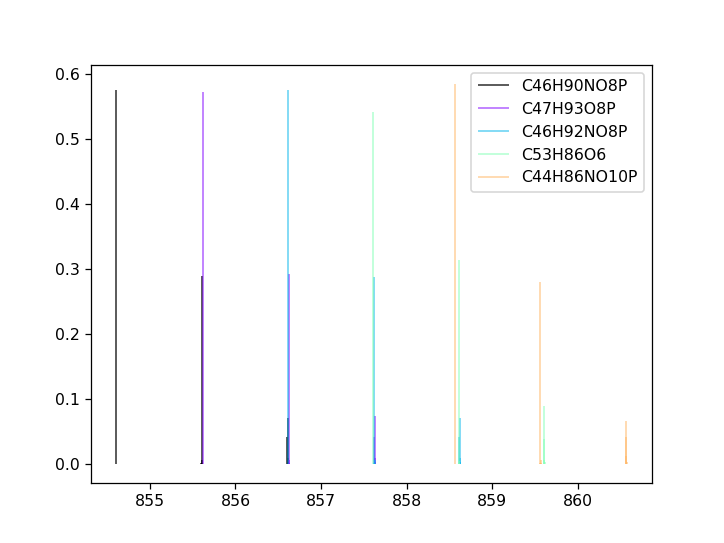

In [13]:
plt.figure()
Spectrum.plot_all(query_spectra)

In [14]:
profile_regression_images = np.zeros(image_shape  + (len(spectra), ))
centroid_regression_images = np.zeros(image_shape + (len(spectra), ))

In [15]:
MTD_values = [0.05, 0.1, 0.2, 0.4, 0.6]

0
500
1000
1500
2000


<IPython.core.display.Javascript object>


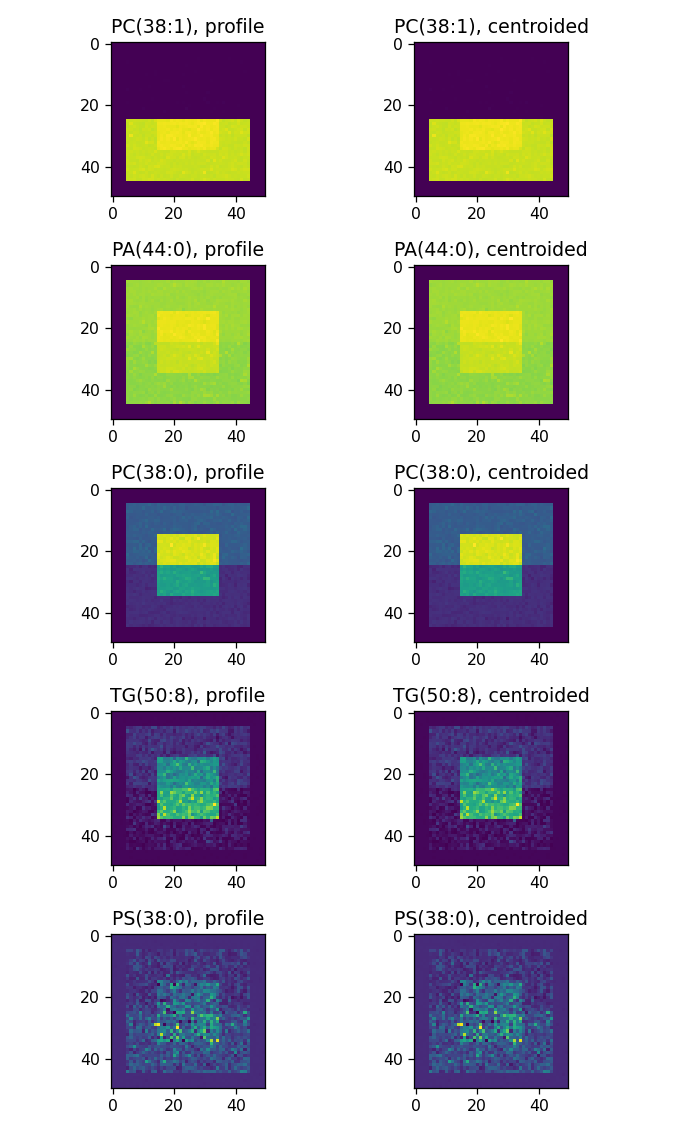

0
500
1000
1500
2000


<IPython.core.display.Javascript object>


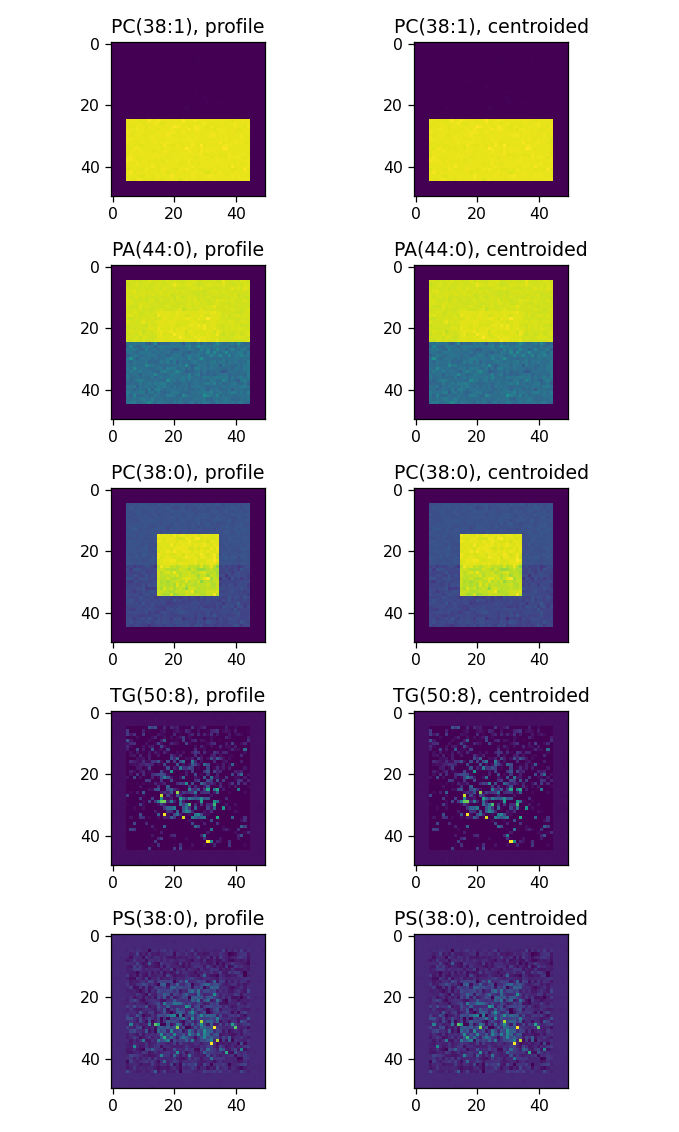

0
500
1000
1500
2000


<IPython.core.display.Javascript object>


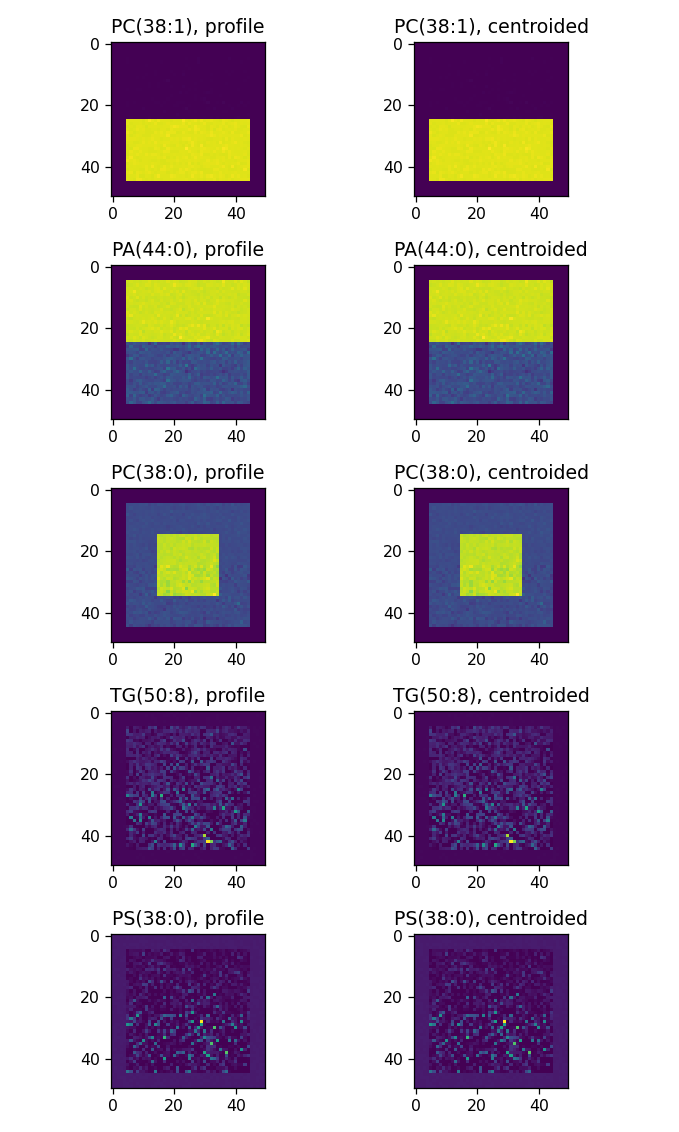

0
500
1000
1500
2000


<IPython.core.display.Javascript object>


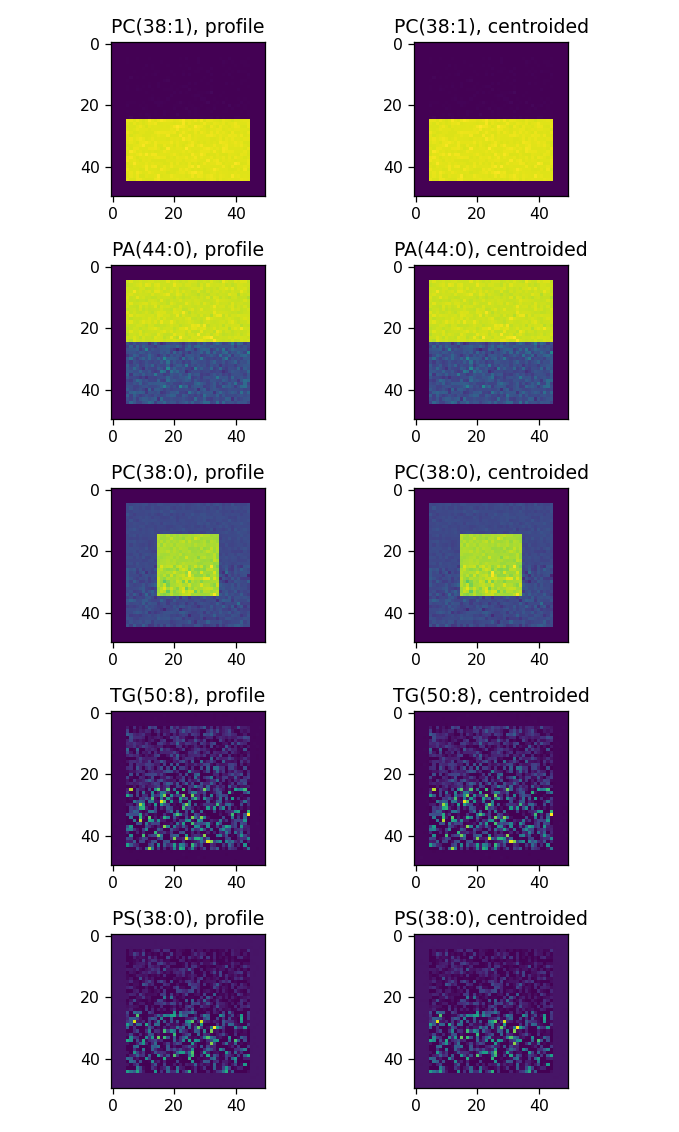

0
500
1000
1500
2000


<IPython.core.display.Javascript object>


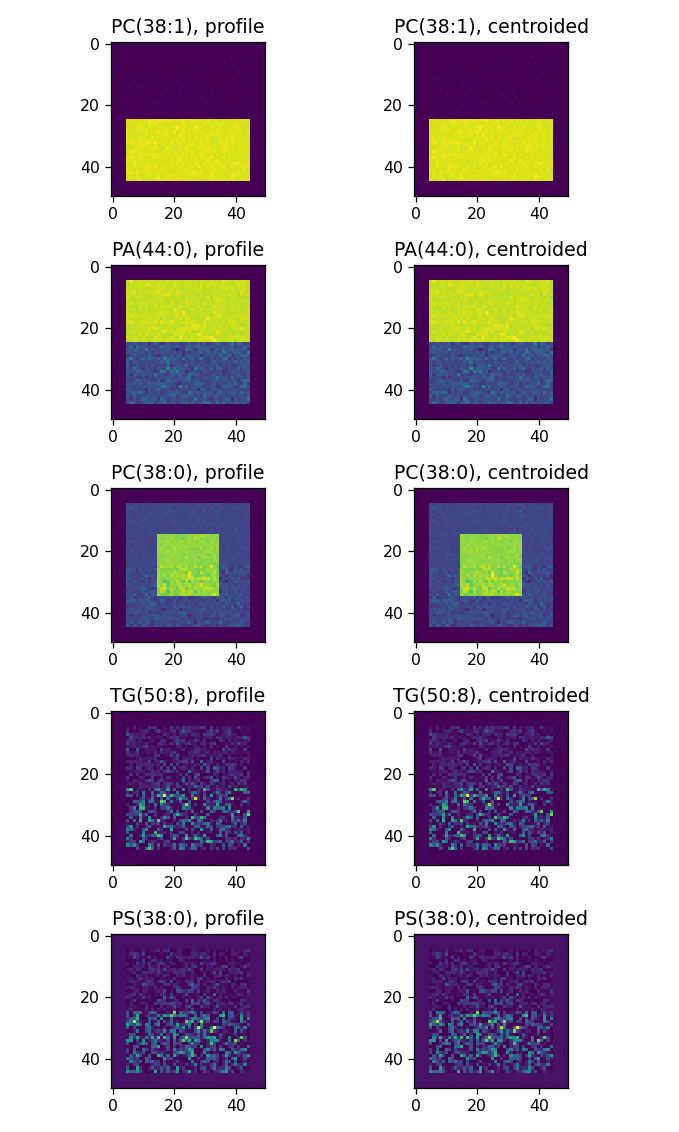

In [16]:
for mtd in MTD_values:
    for idx, (x,y,z) in enumerate(profile_image.coordinates):
        if not idx%500:
            print(idx)
        PS = Spectrum(confs=list(zip(*profile_image.getspectrum(idx))))
        PS_TIC = np.trapz([x[1] for x in PS.confs], [x[0] for x in PS.confs])
        PS.normalize()
        CS = Spectrum(confs=list(zip(*profile_image.getspectrum(idx))))
        CS_TIC = sum(x[1] for x in CS.confs)
        CS.normalize()
        Preg = estimate_proportions(PS, spectra, MTD=mtd)
        Creg = estimate_proportions(CS, spectra, MTD=mtd)
        profile_regression_images[x,y,:] = Preg['proportions']
        profile_regression_images[x,y,:] *= PS_TIC
        centroid_regression_images[x,y,:] = Creg['proportions']
        centroid_regression_images[x,y,:] *= CS_TIC

    plt.figure(figsize=(6, 2*len(spectra)))
    for i in range(len(spectra)):
        plt.subplot(len(spectra), 2, 1+2*i)
        plt.title('%s, profile' % spectra[i].label)
        plt.imshow(profile_regression_images[:,:,i])
        plt.subplot(len(spectra), 2, 2+2*i)
        plt.title('%s, centroided' % spectra[i].label)
        plt.imshow(centroid_regression_images[:,:,i])
    plt.tight_layout()
    plt.savefig('lipid_deconvolution_MTD%f.pdf' % mtd)
    
    with open('deconvolution_results_profile_MTD%f.tsv' % mtd, 'w') as h:
        h.write('X\tY\t' + '\t'.join(names) + '\n') 
        for x in range(profile_regression_images.shape[0]):
            for y in range(profile_regression_images.shape[1]):
                h.write(str(x)+'\t'+str(y)+'\t')
                for i in range(profile_regression_images.shape[2]):
                    h.write(str(profile_regression_images[x,y,i]) + '\t')
                h.write('\n')
            
    with open('deconvolution_results_centroid_MTD%f.tsv' % mtd, 'w') as h:
        h.write('X\tY\t' + '\t'.join(names) + '\n') 
        for x in range(centroid_regression_images.shape[0]):
            for y in range(centroid_regression_images.shape[1]):
                h.write(str(x)+'\t'+str(y)+'\t')
                for i in range(centroid_regression_images.shape[2]):
                    h.write(str(centroid_regression_images[x,y,i]) + '\t')
                h.write('\n')

<IPython.core.display.Javascript object>


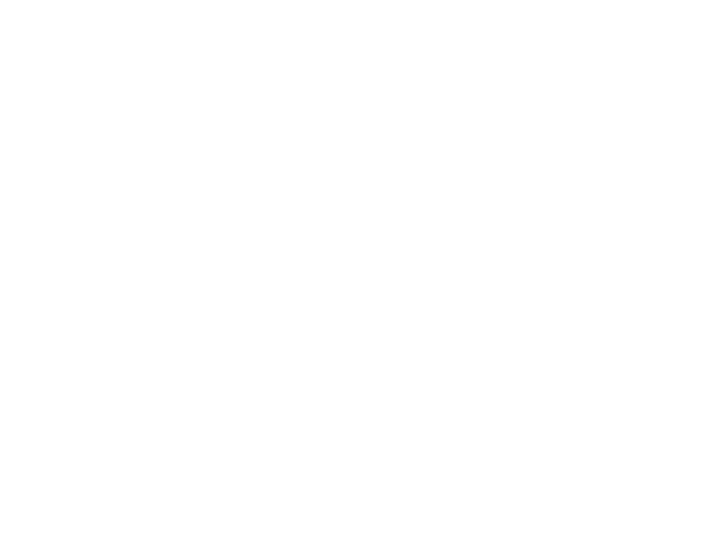

In [18]:
plt.figure()
plt.subplot(1, 2, 1)
plt.title('Profile, lipid %i' % i)
plt.imshow(profile_regression_images[:,:,1])
plt.subplot(1, 2, 2)
plt.title('Centroided, lipid %i' % i)
plt.imshow(centroid_regression_images[:,:,1])

In [19]:
PS_TIC

526.2891326642515

### Side note: Centroiding leads to information loss in case of overlapping peaks 
This is because a profile peak may be lower but wider while having the same area.  
Overlapping envelopes give broader but lower peaks.  

In [22]:
idx1 = profile_image.coordinates.index((25, 30, 1))
idx2 = profile_image.coordinates.index((25, 60, 1))

ValueError: (25, 60, 1) is not in list

In [ ]:
PS1 = Spectrum(confs=list(zip(*profile_image.getspectrum(idx1))))
PS2 = Spectrum(confs=list(zip(*profile_image.getspectrum(idx2))))
CS1 = Spectrum(confs=list(zip(*centroid_image.getspectrum(idx1))))
CS2 = Spectrum(confs=list(zip(*centroid_image.getspectrum(idx2))))

In [ ]:
plt.figure(figsize=(8,5))
plt.subplot(221)
PS1.plot(profile=True, show=False)
plt.ylim(-100, 2000)
plt.plot(850.57, 0, 'r+')
plt.subplot(222)
CS1.plot(profile=False, show=False)
plt.ylim(-10, 250)
plt.plot(850.57, 0, 'r+')
plt.subplot(223)
PS2.plot(profile=True, show=False)
plt.ylim(-100, 2000)
plt.plot(850.57, 0, 'r+')
plt.subplot(224)
CS2.plot(profile=False, show=False)
plt.ylim(-10, 250)
plt.plot(850.57, 0, 'r+')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8,4))
plt.subplot(121)
PS1.plot(profile=True, show=False)
plt.ylim(-100, 2000)
plt.xlim(850.25, 850.85)
plt.plot(850.57, 0, 'r+')
plt.subplot(122)
PS2.plot(profile=True, show=False)
plt.ylim(-100, 2000)
plt.xlim(850.25, 850.85)
plt.plot(850.57, 0, 'r+')
plt.tight_layout()
plt.show()

Those two peaks have different heights, but similar areas - this is because there are two very similar lipids there with different proportions; On the left, we mostly have one lipid, while on the right the lipids have similar proportions, making the profile peak broader (since their peaks merge due to low resolution)